In [40]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from matplotlib import pyplot as plt

import lightgbm as lgb

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [41]:
items = pd.read_csv('../sale-prediction/items.csv')
shops = pd.read_csv('../sale-prediction/shops.csv')
cats = pd.read_csv('../sale-prediction/item_categories.csv')
train = pd.read_csv('../sale-prediction/sales_train.csv')
test = pd.read_csv('../sale-prediction/test.csv').set_index('ID')

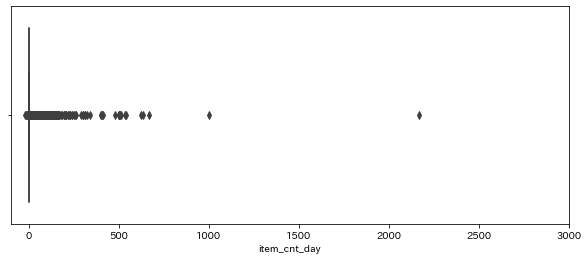

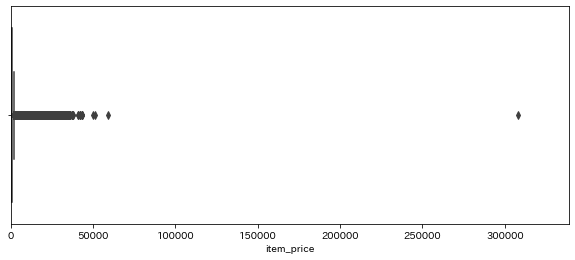

In [42]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)

sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [43]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001] #外れ値の除去

In [44]:
median = train[(train.shop_id==32)&(train.item_id==2937)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median  #修正できてなくない？

In [45]:
train.loc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price               NaN
item_cnt_day               1
Name: 484683, dtype: object

In [46]:
train.loc[train.item_id==2937].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,79.000000,79.000000,79.0,79.000000,79.000000
mean,28.227848,31.316456,2937.0,1058.490759,1.025316
std,2.331223,17.850910,0.0,191.101952,0.158088
min,26.000000,2.000000,2937.0,799.000000,1.000000
25%,27.000000,16.000000,2937.0,856.200000,1.000000
50%,27.000000,31.000000,2937.0,1199.000000,1.000000
75%,28.500000,47.000000,2937.0,1199.000000,1.000000
max,33.000000,59.000000,2937.0,1399.000000,2.000000


In [47]:
train.iat[484683, 4] = 1199
train.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price              1199
item_cnt_day               1
Name: 484683, dtype: object

In [48]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
#かぶっている店の名前を変更。ほかにもあって気がするが。

## Shops/Cats/Items preprocessing

In [49]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


In [50]:
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']] #この二つだけにしちゃうんだ

In [125]:
cats

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
...,...,...,...
79,79,16,54
80,80,16,25
81,81,17,62
82,82,18,63


In [52]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]



In [53]:
items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales

In [54]:
(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))),
 len(list(set(test.item_id))),
 len(test))

(363, 5100, 214200)

In [68]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [69]:
train['revenue'] = train.item_price * train.item_cnt_day

In [70]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float16))

In [71]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [72]:
matrix = pd.concat([matrix, test],ignore_index=True, sort=False, keys=cols)
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,NaN
11128000,34,45,16188,NaN
11128001,34,45,15757,NaN
11128002,34,45,19648,NaN


## Shops/Items/Cats features

In [73]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,NaN,20,55,13,2
11128000,34,45,16188,NaN,20,64,14,42
11128001,34,45,15757,NaN,20,55,13,2
11128002,34,45,19648,NaN,20,40,11,4


## Target lags

In [74]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy() #forの性質上の理由
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)] #ずらしたカラム名
        shifted['date_block_num'] += i #date_block_numをずらす
        df = pd.merge(df, shifted, on=['date_block_num', 'item_id', 'shop_id'], how='left')
    return df


In [75]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix
#これを入れるとスコアが下がる

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,NaN,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,NaN,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,NaN,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,NaN,20,40,11,4,0.0,0.0,0.0,0.0,NaN


In [76]:
shop2_item32 = matrix.loc[matrix.shop_id == 31].loc[matrix.item_id == 20341]
shop2_item32

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
2849645,7,31,20341,1.0,13,72,14,59,NaN,NaN,NaN,NaN,NaN
3207186,8,31,20341,0.0,13,72,14,59,1.0,NaN,NaN,NaN,NaN
3573560,9,31,20341,0.0,13,72,14,59,0.0,1.0,NaN,NaN,NaN
3936672,10,31,20341,0.0,13,72,14,59,0.0,0.0,1.0,NaN,NaN
4310240,11,31,20341,0.0,13,72,14,59,0.0,0.0,0.0,NaN,NaN
6333093,17,31,20341,0.0,13,72,14,59,NaN,NaN,NaN,0.0,NaN


## Mean encoded features

In [77]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月に平均何個売れているのか。これ意味ある？

,date_block_num,date_avg_item_cnt
0,0,0.347168
1,1,0.324463
2,2,0.355469
3,3,0.275391
4,4,0.265137


In [78]:
matrix = pd.merge(matrix, group, on=['date_block_num'],how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', axis=1, inplace=True)
#ラグ化

In [86]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月にその商品が店舗平均何個売れたのか。これのほうが意味ありそう。

,date_block_num,item_id,date_item_avg_item_cnt
0,0,19,0.022217
1,0,27,0.155518
2,0,28,0.177734
3,0,29,0.088867
4,0,32,5.378906


In [84]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
#マージしてラグ化

In [109]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月にそのショップで、商品当たり何個売れたのか

,date_block_num,shop_id,date_shop_avg_item_cnt
0,0,2,0.141235
1,0,3,0.094543
2,0,4,0.257324
3,0,6,0.438721
4,0,7,0.305908


In [112]:
p = matrix.loc[matrix.date_block_num == 0].loc[matrix.shop_id == 2]
sum(p.item_cnt_month)/8115 #なぜか少しずれる

0.14121996303142328

In [113]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [114]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月のそのitem_categoryが平均何個売られたのか。
#イメージしづらい。これはsumのほうが良いのでは？

,date_block_num,item_category_id,date_cat_avg_item_cnt
0,0,0,0.022217
1,0,1,0.022217
2,0,2,0.835449
3,0,3,4.421875
4,0,4,0.513184


In [115]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12],'date_cat_avg_item_cnt')
matrix.drop('date_cat_avg_item_cnt', axis=1, inplace=True)

#ラグ化

In [118]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月にそのショップでそのitem_catが平均いくつ売れたのか
#平均の意味がよくわからない

,date_block_num,shop_id,item_category_id,date_shop_cat_avg_item_cnt
0,0,2,0,0.000000
1,0,2,1,0.000000
2,0,2,2,0.675781
3,0,2,3,4.500000
4,0,2,4,0.909180


In [121]:
p = matrix.loc[matrix.date_block_num == 0].loc[matrix.shop_id == 2].loc[matrix.item_category_id == 3]
p
#この二つの平均値をとることに何の意味があるのか

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12
1758,0,2,5652,0.0,0,3,1,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4855,0,2,13071,9.0,0,3,1,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
#なぜこれだけが1ヶ月だけのラグなのか

In [129]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#その月にそのショップでは平均何個の各typeが売られたのか。疑問は同様。

,date_block_num,shop_id,type_code,date_shop_type_avg_item_cnt
0,0,2,0,0.000000
1,0,2,1,0.680176
2,0,2,3,0.000000
3,0,2,4,0.444336
4,0,2,5,0.427002


In [130]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
#なぜこれも1か月分のみなのか。

In [132]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
group.head()
#上と同様
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [133]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
group.head()
#これこそ合計のほうがよくないかｗ

,date_block_num,city_code,date_city_avg_item_cnt
0,0,0,0.141235
1,0,1,0.094543
2,0,2,0.257324
3,0,4,0.308350
4,0,6,0.115234


In [134]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [135]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
group.head()
#その月にその商品がその都市で店舗平均どのくらい売れたのか

,date_block_num,item_id,city_code,date_item_city_avg_item_cnt
0,0,19,0,0.0
1,0,19,1,0.0
2,0,19,2,0.0
3,0,19,4,0.0
4,0,19,6,0.0


In [136]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
#ラグ化

In [137]:
group = matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)
group.head()
#その月にそのタイプが平均何個売られたのか。意味ある？

,date_block_num,type_code,date_type_avg_item_cnt
0,0,0,0.022217
1,0,1,0.810547
2,0,3,0.311035
3,0,4,0.430664
4,0,5,0.727539


In [138]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
#ラグ化

In [140]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
#同上

## ここまでのものをモデリング

In [144]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_x', 'date_item_avg_item_cnt_y',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_a

In [145]:
matrix.drop(['date_item_avg_item_cnt_y'], axis=1, inplace=True)

In [147]:
for i in range(len(matrix.columns)):
    matrix.iloc[:,i].fillna(0, inplace=True)

In [148]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0,2,27,1.0,0,19,5,10,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0,2,28,0.0,0,30,8,55,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0,2,29,0.0,0,23,5,16,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0,2,32,0.0,0,40,11,4,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,...,0.217285,0.206909,0.000000,0.126831,0.089294,0.126831,0.135376,0.5,0.146973,0.196899
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,...,0.000000,0.000000,0.000000,0.094482,0.106201,0.094482,0.135376,0.0,0.237305,0.155884
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,...,0.217285,0.206909,0.248047,0.126831,0.089294,0.126831,0.135376,0.0,0.146973,0.196899
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,...,0.242188,0.227417,0.000000,0.083740,0.097046,0.083740,0.135376,0.0,0.224243,0.220825


In [149]:
matrix.to_csv('data_lag.csv')

In [150]:
data = pd.read_csv('../sale-prediction写経/data_lag.csv')

In [156]:
data['month'] = data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
data['days'] = data['month'].map(days).astype(np.int8)

In [159]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [160]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [161]:
import lightgbm as lightgbm
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'month', 'type_code', 'subtype_code']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          "learning_rate" : 0.01,
          }

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=1000)

time.time() - ts

Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.574876	valid_1's rmse: 0.687176
[2000]	training's rmse: 0.550416	valid_1's rmse: 0.682634
[3000]	training's rmse: 0.535005	valid_1's rmse: 0.680485
[4000]	training's rmse: 0.522801	valid_1's rmse: 0.678809
Early stopping, best iteration is:
[4347]	training's rmse: 0.518981	valid_1's rmse: 0.677968


3933.755490064621

In [162]:
import numpy as np
from sklearn.metrics import mean_squared_error
va_pred = model.predict(X_valid)
score = np.sqrt(mean_squared_error(Y_valid, va_pred))
score

0.6749190900091717

In [163]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_lags_sub.csv', index=False)
#1.22596

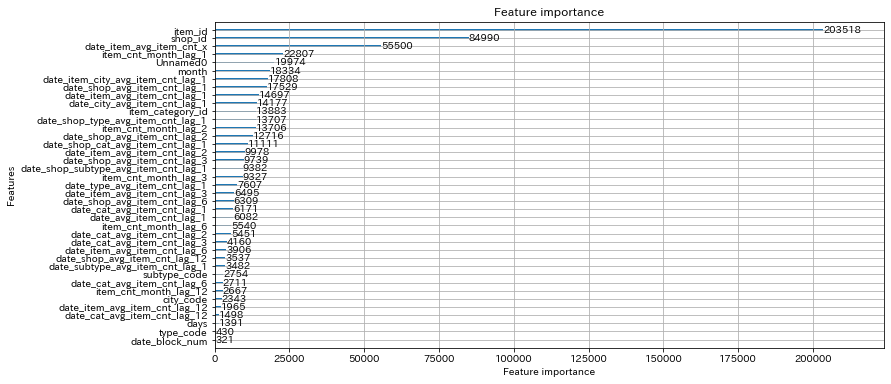

In [164]:
lightgbm.plot_importance(model, figsize=(12, 6))